In [1]:
import sys
sys.path.append("../../SiMaC/")

In [2]:
import os
import string
import time

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

from src.dataset.toy import ToyDataset
from src.ml.model import SiMaC, SiMaCImplicit
from src.ml.layers import ScaledEmbedding
from src.ml.sinkhorn import SinkhornLoss, sinkhorn
from src.ml.train import assign_with_lap
from src import viz

In [3]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

In [4]:
%load_ext autoreload

In [5]:
FIG_SAVE_PATH = os.path.join("..", "paper", "figures")

In [6]:
%autoreload 2

# Dataset

In [7]:
n_centers = 3
n_items = 3
n_users = 1000
distance_weight = 0.3
n_features = 2

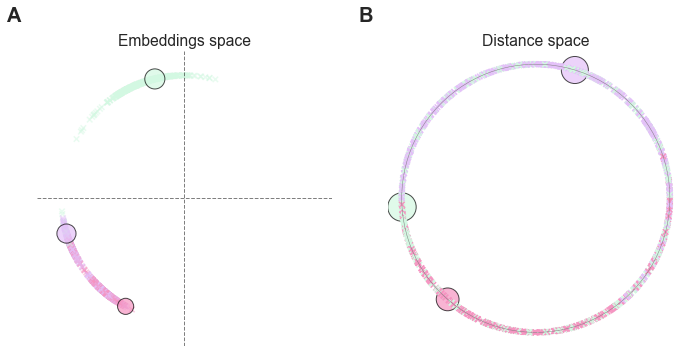

In [8]:
toy = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    n_features=n_features,
    distance_weight=distance_weight
)

fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    items_features=torch.from_numpy(toy.items_features),
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    toy.circle_radius,
    toy.assigned_item_for_user,
    toy.items_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

# Training

In [8]:
sinkhorn_n_iter = 100
sinkohrn_epsilon = 0.05
n_epochs = 200
learning_rate = 0.005

## SiMaC

In [9]:
def train_simac(toy):
    model = SiMaC(
        capacities=toy.items_capacities,
        n_users=toy.n_users,
        alpha=distance_weight,
        n_features=n_features,
        n_iter=sinkhorn_n_iter,
        epsilon=sinkohrn_epsilon,
        user_embeddings=torch.FloatTensor(toy.users_features),
        train_user_embeddings=False
    )

    optimizer = torch.optim.Adam(lr=learning_rate, params=model.parameters())
    criterion = torch.nn.NLLLoss()

    #########
    # Train #
    #########

    model.train()

    stats = []

    for epoch in range(n_epochs):
        start_time = time.time()
        train_epoch_loss = 0
        optimizer.zero_grad()

        # Model out
        P = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)

        # Loss
        loss = criterion(torch.log(P), toy.y_true_tensor)
        loss.backward()
        optimizer.step()
        
        epoch_duration = 1000 * (time.time() - start_time)

        # Predictions
        y_pred = assign_with_lap(P, toy.items_capacities)
        f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")

        stats.append([loss.item(), f1, epoch_duration])

    print("Epoch {0}: loss={1:3f}, F1={2:.3f}".format(epoch+1, loss.item(), f1))
    
    return stats

In [10]:
_ = train_simac(toy)

NameError: name 'toy' is not defined

## SiMaC with implicit layers

In [16]:
def train_simac_implicit(toy):
    # define model, loss & optimizer
    model = SiMaCImplicit(
        capacities=toy.items_capacities,
        n_users=toy.n_users,
        alpha=distance_weight,
        n_features=n_features,
        user_embeddings=torch.FloatTensor(toy.users_features),
        train_user_embeddings=False
    )

    a = torch.ones(toy.n_users)
    b = torch.FloatTensor(toy.items_capacities).view(-1)

    sinkhorn_loss = SinkhornLoss(
        a=a,
        b=b,
        solver=sinkhorn,
        n_iter=sinkhorn_n_iter,
        epsilon=sinkohrn_epsilon
    )

    optimizer = torch.optim.Adam(lr=learning_rate, params=model.parameters())
    
    target = torch.nn.functional.one_hot(
        torch.tensor(toy.assigned_item_for_user),
        num_classes=toy.n_items
    )

    #########
    # Train #
    #########

    model.train()

    stats = []

    for epoch in range(n_epochs):
        start_time = time.time()
        train_epoch_loss = 0
        optimizer.zero_grad()

        # Model out
        M = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)

        # Loss
        loss = sinkhorn_loss(M, target)
        loss.backward()
        optimizer.step()
        
        epoch_duration = 1000 * (time.time() - start_time)

        with torch.no_grad():
            P = sinkhorn(M, a, b, sinkohrn_epsilon, sinkhorn_n_iter)

        # Predictions
        y_pred = assign_with_lap(P, toy.items_capacities)
        f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")

        stats.append([loss.item(), f1, epoch_duration])

    print("Epoch {0}: loss={1:3f}, F1={2:.3f}".format(epoch+1, loss.item(), f1))
    
    return stats

In [58]:
_ = train_simac_implicit(toy)

Epoch 200: loss=78.304031, F1=0.971


# Experiments

## Run multiple trainings

In [14]:
n_trainings = 20

In [62]:
print("---- Running {0} trainings of SiMaC ----".format(n_trainings))
simac_results = [train_simac(toy) for i in range(n_trainings)]

print("\n---- Running {0} trainings of SiMaC with implicit layers ----".format(n_trainings))
simac_implicit_results = [train_simac_implicit(toy) for i in range(n_trainings)]

---- Running 20 trainings of SiMaC ----
Epoch 200: loss=0.097503, F1=0.946
Epoch 200: loss=0.098812, F1=0.958
Epoch 200: loss=0.070834, F1=0.972
Epoch 200: loss=0.045941, F1=0.979
Epoch 200: loss=0.399098, F1=0.822
Epoch 200: loss=0.314769, F1=0.848
Epoch 200: loss=0.075570, F1=0.960
Epoch 200: loss=0.081268, F1=0.955
Epoch 200: loss=0.082585, F1=0.961
Epoch 200: loss=0.426180, F1=0.813
Epoch 200: loss=0.235369, F1=0.879
Epoch 200: loss=0.157245, F1=0.907
Epoch 200: loss=0.091301, F1=0.946
Epoch 200: loss=0.059586, F1=0.969
Epoch 200: loss=0.092605, F1=0.956
Epoch 200: loss=0.065470, F1=0.976
Epoch 200: loss=0.351938, F1=0.851
Epoch 200: loss=0.113518, F1=0.947
Epoch 200: loss=0.347142, F1=0.845
Epoch 200: loss=0.044553, F1=0.980

---- Running 20 trainings of SiMaC with implicit layers ----
Epoch 200: loss=427.207336, F1=0.827
Epoch 200: loss=128.182678, F1=0.926
Epoch 200: loss=170.517685, F1=0.895
Epoch 200: loss=88.339775, F1=0.946
Epoch 200: loss=97.032768, F1=0.949
Epoch 200: loss

In [63]:
assert np.asarray(simac_results).shape == (n_trainings, n_epochs, 3)
assert np.asarray(simac_implicit_results).shape == (n_trainings, n_epochs, 3)

In [64]:
results_dfs = []

for results in [simac_results, simac_implicit_results]:
    dfs = []
    
    for run_index, run_stats in enumerate(results):
        run_stats_df = pd.DataFrame(run_stats, columns=["loss", "F1", "epoch_duration"])
        run_stats_df["run_index"] = run_index+1
        run_stats_df["epoch"] = np.arange(1, n_epochs+1)

        dfs.append(run_stats_df)
    df = pd.concat(dfs)
    results_dfs.append(df)
        
simac_results_df, simac_implicit_results_df = results_dfs[0], results_dfs[1]

## Plot scores

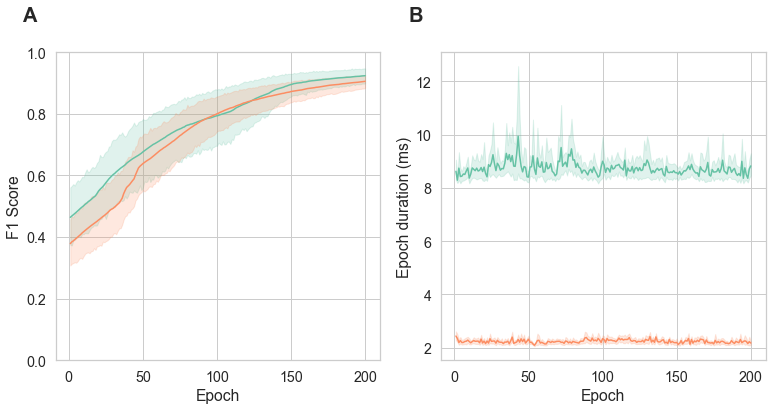

In [65]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(11, 6),
    sharex=True
)

############
# F1 score #
############

ax = axs[0]
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

sns.lineplot(
    data=simac_results_df.reset_index(),
    x="epoch",
    y="F1",
    ax=ax
)

sns.lineplot(
    data=simac_implicit_results_df.reset_index(),
    x="epoch",
    y="F1",
    ax=ax
)

##################
# Epoch duration #
##################

ax = axs[1]
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch duration (ms)")

sns.lineplot(
    data=simac_results_df.reset_index(),
    x="epoch",
    y="epoch_duration",
    ax=ax
)

sns.lineplot(
    data=simac_implicit_results_df.reset_index(),
    x="epoch",
    y="epoch_duration",
    ax=ax
)

# Annotate subplots with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

## Dataset robustness

In [12]:
toy_datasets = []

for _ in range(5):
    toy_tmp = ToyDataset(
        n_centers=n_centers,
        n_items=n_items,
        n_users=n_users,
        n_features=n_features,
        distance_weight=distance_weight
    )
    
    toy_datasets.append(toy_tmp)

In [18]:
print("---- Running {0} trainings of SiMaC on {1} datasets ----".format(5, 5))
simac_results = [[train_simac(toy_tmp) 
                  for _ in range(5)] 
                 for toy_tmp in toy_datasets]

print("\n---- Running {0} trainings of SiMaC with implicit layers on {1} datasets ----".format(5, 5))
simac_implicit_results = [[train_simac_implicit(toy_tmp) 
                           for _ in range(5)] 
                          for toy_tmp in toy_datasets]

---- Running 5 trainings of SiMaC ----
Epoch 200: loss=0.055197, F1=0.979
Epoch 200: loss=0.076470, F1=0.962
Epoch 200: loss=0.056251, F1=0.976
Epoch 200: loss=0.048441, F1=0.977
Epoch 200: loss=0.041508, F1=0.979
Epoch 200: loss=0.114912, F1=0.962
Epoch 200: loss=0.096480, F1=0.950
Epoch 200: loss=0.085324, F1=0.956
Epoch 200: loss=0.112627, F1=0.967
Epoch 200: loss=0.102744, F1=0.950
Epoch 200: loss=0.180119, F1=0.951
Epoch 200: loss=0.299252, F1=0.957
Epoch 200: loss=0.164966, F1=0.953
Epoch 200: loss=0.413696, F1=0.829
Epoch 200: loss=0.217291, F1=0.955
Epoch 200: loss=0.109844, F1=0.958
Epoch 200: loss=0.107605, F1=0.975
Epoch 200: loss=0.124977, F1=0.961
Epoch 200: loss=0.158356, F1=0.939
Epoch 200: loss=0.242795, F1=0.902
Epoch 200: loss=0.218447, F1=0.912
Epoch 200: loss=0.072654, F1=0.971
Epoch 200: loss=0.117882, F1=0.972
Epoch 200: loss=0.095667, F1=0.964
Epoch 200: loss=0.231394, F1=0.954

---- Running 5 trainings of SiMaC with implicit layers ----
Epoch 200: loss=389.29721

In [21]:
np.asarray(simac_implicit_results).shape

(5, 5, 200, 3)

In [33]:
results_dfs = []

for results in [simac_results, simac_implicit_results]:
    dfs = []
    
    for i in range(5):
        for run_index, run_stats in enumerate(results[i]):
            run_stats_df = pd.DataFrame(run_stats, columns=["loss", "F1", "epoch_duration"])
            run_stats_df["dataset_index"] = i+1
            run_stats_df["run_index"] = run_index+1
            run_stats_df["epoch"] = np.arange(1, n_epochs+1)

            dfs.append(run_stats_df)
    df = pd.concat(dfs)
    results_dfs.append(df)
        
simac_results_df, simac_implicit_results_df = results_dfs[0], results_dfs[1]

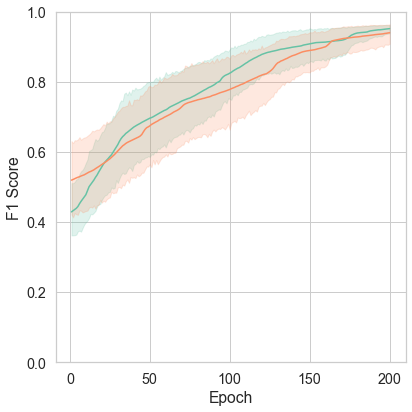

In [35]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 6),
    sharex=True
)

############
# F1 score #
############

ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

sns.lineplot(
    data=simac_results_df.reset_index(),
    x="epoch",
    y="F1",
    ax=ax
)

sns.lineplot(
    data=simac_implicit_results_df.reset_index(),
    x="epoch",
    y="F1",
    ax=ax
)

plt.tight_layout()
plt.show()